# Spatial Statistics Workshop

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import comb
from sklearn.metrics.pairwise import haversine_distances,euclidean_distances
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


## Bring in the data we just made:

In [4]:
# Bring in Data.
df = pd.read_csv('geostatistics_data.txt')
df = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Long, df.Lat))

N = df.shape[0]


## Here's what it looks like:

In [5]:
df

,Location,Name,PairID,Dollars,Busiest,Rating,Lat,Long,geometry
0,DC,Peacock Cafe,1,2,13,4.4,38.90624,-77.06387,POINT (-77.06387 38.90624)
1,DC,Cafe Milano,1,3,20,4.4,38.90626,-77.06365,POINT (-77.06365 38.90626)
2,DC,The Midlands Beer Garden,2,2,19,4.4,38.93191,-77.02330,POINT (-77.02330 38.93191)
3,DC,Hook Hall,2,2,22,4.3,38.93230,-77.02388,POINT (-77.02388 38.93230)
4,Baltimore,Phillips Seafood,3,2,19,4.1,39.28646,-76.60717,POINT (-76.60717 39.28646)
5,Baltimore,Hard Rock Cafe,3,2,14,4.0,39.28610,-76.60712,POINT (-76.60712 39.28610)
6,Harper's Ferry,Kelley Farm Kitchen,4,-1,13,4.9,39.32645,-77.74629,POINT (-77.74629 39.32645)
7,Harper's Ferry,Snallygaster's,4,-1,13,5.0,39.32640,-77.74610,POINT (-77.74610 39.32640)
8,Verviers (BE),McDonald's,5,2,13,3.8,50.58896,5.84952,POINT (5.84952 50.58896)
9,Verviers (BE),El Camino,5,-1,19,4.4,50.59023,5.84809,POINT (5.84809 50.59023)


## And here's where it's from:

<Figure size 432x288 with 0 Axes>

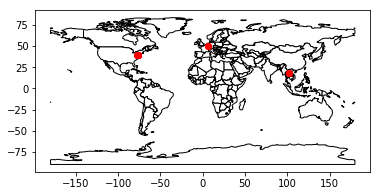

In [6]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig = plt.figure()
ax = world.plot(color='white', edgecolor='black')
df.plot(ax=ax, color='red')

## Question: Are neighboring restaurants more similar than randomly chosen pairs?

In [77]:
# Calculate Difference between pairs of data
target = df['Rating']
pair_diffs = np.zeros(N//2)
for i in range(N//2):
    ind1 = 2*i
    ind2 = 2*i+1
    pair_diffs[i] = abs(target[ind1] - target[ind2])

all_diffs = np.zeros(shape = [N,N])
for ind1 in range(N):
    for ind2 in range(N):
        all_diffs[ind1,ind2] = abs(target[ind1] - target[ind2])
diffs_vec = all_diffs[np.tril_indices(N, k = -1)]

print(np.mean(diffs_vec))
print(np.mean(pair_diffs))

0.3984848484848486
0.18333333333333343


# Exploring Correlation

## What's correlated?

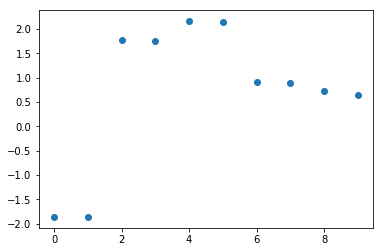

In [8]:
K = 10
x = np.random.normal(size=K)

covmat = np.eye(K)
corr = 0.999
for b in range(K//2):
    covmat[2*b,2*b+1] = covmat[2*b+1,2*b] = corr
L = np.linalg.cholesky(covmat)
x = L @ x

plt.scatter(range(len(x)), x)
#print(covmat)

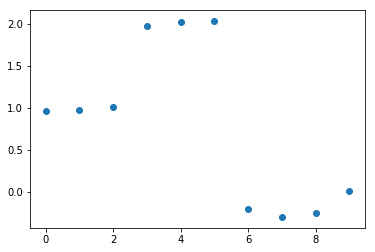

In [9]:
K = 10
x = np.random.normal(size=K)

covmat = np.eye(K)
corr = 0.999
for b in range(K//3):
    covmat[3*b,3*b+1] = covmat[3*b+1,3*b] = corr
    covmat[3*b,3*b+2] = covmat[3*b+2,3*b] = corr
    covmat[3*b+1,3*b+2] = covmat[3*b+2,3*b+1] = corr
L = np.linalg.cholesky(covmat)
x = L @ x

plt.scatter(range(len(x)), x)
#print(covmat)

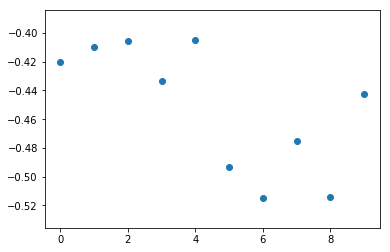

In [10]:
#### What's a Covariance/Correlation?
K = 10
x = np.random.normal(size=K)

corr = 0.999
covmat = np.concatenate([np.concatenate([(1-corr)*np.eye(K//2)+corr*np.ones([K//2,K//2]), np.zeros([K//2,K//2])]), np.concatenate([np.zeros([K//2,K//2]), (1-corr)*np.eye(K//2)+corr*np.ones([K//2,K//2])])], axis = 1)

L = np.linalg.cholesky(covmat)
x = L @ x

plt.scatter(range(len(x)), x)
#print(covmat)

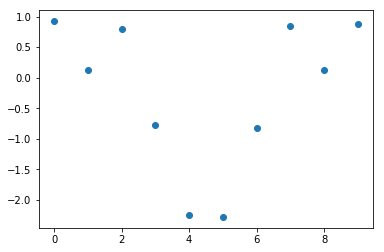

In [11]:
#### What's a Covariance/Correlation?
K = 10
x = np.random.normal(size=K)

covmat = np.eye(K)
corr = 0.999
for b in range(K//2):
    covmat[2*b,K-2*b-1] = covmat[K-2*b-1,2*b] = corr
L = np.linalg.cholesky(covmat)
x = L @ x

plt.scatter(range(len(x)), x)
#print(covmat)

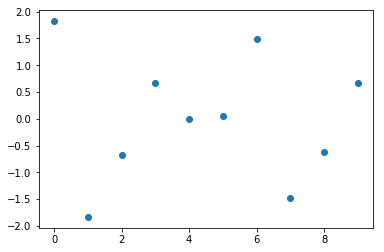

In [12]:
K = 10
x = np.random.normal(size=K)

covmat = np.eye(K)
corr = 0.999
for b in range(K//2):
    covmat[2*b,2*b+1] = covmat[2*b+1,2*b] = -corr
L = np.linalg.cholesky(covmat)
x = L @ x

plt.scatter(range(len(x)), x)
#print(covmat)

# What Correlation Matrix should we use for our Data? Option 1: Pairs.

In [13]:
paired_covmat = np.eye(N)
corr = 0.5
for b in range(N//2):
    paired_covmat[2*b,2*b+1] = paired_covmat[2*b+1,2*b] = corr
    
print(paired_covmat)

[[1.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.5 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 1. ]]


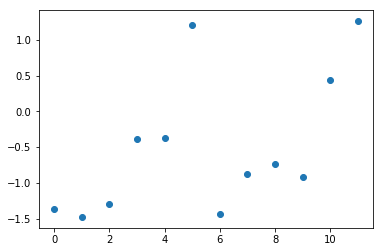

In [14]:
x = np.random.normal(size=N)
L = np.linalg.cholesky(paired_covmat)
x = L @ x

plt.scatter(range(len(x)), x)

## Fitting a Regression

First, a good-ol' "Ordinary Least Squares" regression:

In [15]:
xdat = np.array(df['Dollars']).reshape([N,1])
ydat = df['Rating']
ols_model = sm.OLS(ydat, sm.add_constant(xdat))
results = ols_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     5.124
Date:                Sun, 14 Nov 2021   Prob (F-statistic):             0.0471
Time:                        17:32:36   Log-Likelihood:                -1.4914
No. Observations:                  12   AIC:                             6.983
Df Residuals:                      10   BIC:                             7.953
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4669      0.107     41.772      0.0

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


## Compare to this GLS regression:

In [16]:
xdat = np.array(df['Dollars']).reshape([N,1])
ydat = df['Rating']
gls_model = sm.GLS(ydat, sm.add_constant(xdat), sigma=paired_covmat)
results = gls_model.fit()
print(results.summary())

                            GLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.427
Model:                            GLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     7.438
Date:                Sun, 14 Nov 2021   Prob (F-statistic):             0.0213
Time:                        17:32:40   Log-Likelihood:                 1.0126
No. Observations:                  12   AIC:                             1.975
Df Residuals:                      10   BIC:                             2.945
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4648      0.106     42.200      0.0

## Try it with a different correlation:

In [17]:
paired_covmat = np.eye(N)
corr = 0.5
for b in range(N//2):
    paired_covmat[2*b,2*b+1] = paired_covmat[2*b+1,2*b] = corr
    
xdat = np.array(df['Dollars']).reshape([N,1])
ydat = df['Rating']
gls_model = sm.GLS(ydat, sm.add_constant(xdat), sigma=paired_covmat)
results = gls_model.fit()
print(results.summary())

                            GLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.427
Model:                            GLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     7.438
Date:                Sun, 14 Nov 2021   Prob (F-statistic):             0.0213
Time:                        17:32:43   Log-Likelihood:                 1.0126
No. Observations:                  12   AIC:                             1.975
Df Residuals:                      10   BIC:                             2.945
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4648      0.106     42.200      0.0

## Let's take it more seriously:

In [18]:
## Find the best correlation
corrseq = np.linspace(0, 0.99, num = 100)
print(corrseq)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99]


0.86


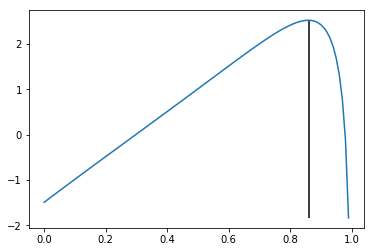

In [19]:
logliks = np.zeros(len(corrseq))
for i,corr in enumerate(corrseq):
    corrmat = np.eye(N)
    for b in range(N//2):
        corrmat[2*b,2*b+1] = corrmat[2*b+1,2*b] = corr

    gls_model = sm.GLS(ydat, sm.add_constant(xdat), sigma=corrmat)
    gls_results = gls_model.fit()
    logliks[i] = gls_results.llf

maximizing = np.argmax(logliks)
plt.plot(corrseq, logliks)
plt.vlines(corrseq[maximizing], ymin = min(logliks), ymax = max(logliks))
print(corrseq[maximizing])

# Covariance Model 2: Smoothly Decreasing Covariance

### Haversine vs Euclidean Distance

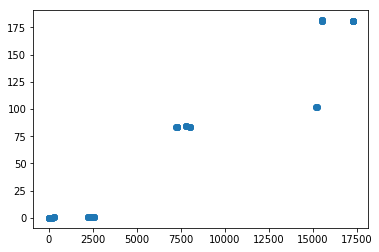

In [20]:
# gives distance in kilometers.
all_dists_haver = 6371000/1000*haversine_distances(df.loc[:,["Lat","Long"]], df.loc[:,["Lat","Long"]])
all_dists_euclid = euclidean_distances(df.loc[:,["Lat","Long"]], df.loc[:,["Lat","Long"]])
haver_vec = all_dists_haver[np.tril_indices(N, k = -1)]
euclid_vec = all_dists_euclid[np.tril_indices(N, k = -1)]

plt.scatter(haver_vec, euclid_vec)

### Variogram:

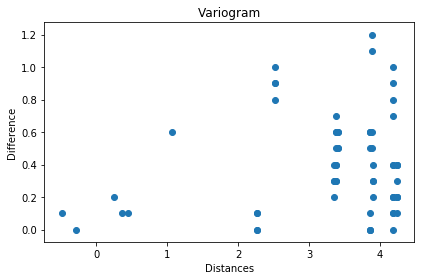

In [21]:

plt.scatter(np.log10(haver_vec), diffs_vec)
#plt.scatter(dists_vec, diffs_vec)
plt.xlabel("Distances")
plt.ylabel("Difference")
plt.title("Variogram")
plt.tight_layout()


### Correlation Functions:

In [48]:
print(all_dists_haver)
dists01 = all_dists_haver / np.max(all_dists_haver)
print(dists01)

[[0.00000000e+00 5.14575493e-01 1.86081845e+02 1.87651793e+02
  2.41200251e+03 2.40992374e+03 2.60596214e+03 2.60573765e+03
  7.32188039e+03 7.31118044e+03 1.72823262e+04 1.72836997e+04]
 [5.14575493e-01 0.00000000e+00 1.85739498e+02 1.87314165e+02
  2.41188496e+03 2.40980598e+03 2.60579055e+03 2.60556611e+03
  7.32141716e+03 7.31071741e+03 1.72826871e+04 1.72840604e+04]
 [1.86081845e+02 1.85739498e+02 0.00000000e+00 2.77009463e+00
  2.25022707e+03 2.24811088e+03 2.43473835e+03 2.43452097e+03
  7.27187888e+03 7.26134027e+03 1.72644440e+04 1.72657319e+04]
 [1.87651793e+02 1.87314165e+02 2.77009463e+00 0.00000000e+00
  2.24771913e+03 2.24560342e+03 2.43238898e+03 2.43217145e+03
  7.27368197e+03 7.26314531e+03 1.72619722e+04 1.72632595e+04]
 [2.41200251e+03 2.41188496e+03 2.25022707e+03 2.24771913e+03
  0.00000000e+00 2.29356593e+00 3.30284306e+02 3.29959622e+02
  8.02212525e+03 8.01413973e+03 1.55370135e+04 1.55376445e+04]
 [2.40992374e+03 2.40980598e+03 2.24811088e+03 2.24560342e+03
  2

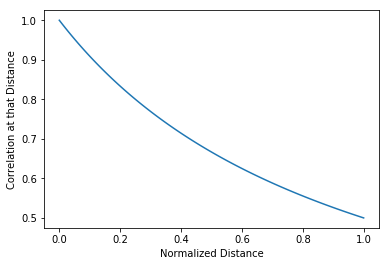

In [49]:
cov_fun = lambda x, l: 1/(1+x*l)
xs = np.linspace(0,1,100)
ys = cov_fun(xs, 1.)

#fig = plt.figure()
plt.plot(xs, ys)
plt.xlabel("Normalized Distance")
plt.ylabel("Correlation at that Distance")
plt.savefig("corr_vs_dist.pdf")

1452.6539259467813


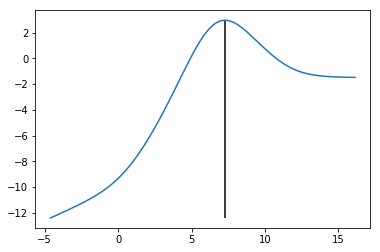

In [54]:
lseq = np.logspace(-2,7,num=1000)

logliks = np.zeros(len(lseq))
for i,l in enumerate(lseq):
    corrmat = cov_fun(dists01, l)

    gls_model = sm.GLS(ydat, sm.add_constant(xdat), sigma=corrmat)
    gls_results = gls_model.fit()
    logliks[i] = gls_results.llf

maximizing = np.argmax(logliks)
plt.plot(np.log(lseq), logliks)
plt.vlines(np.log(lseq[maximizing]), ymin = min(logliks), ymax = max(logliks))
print(lseq[maximizing])

### Overlay it with the variogram:

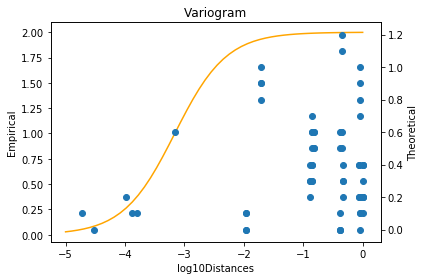

In [73]:
l = lseq[maximizing]

hv01 = haver_vec / np.max(haver_vec)
xs = np.logspace(-5,0)

ax1 = plt.gca()
ax2 = ax1.twinx()  
ax1.plot(np.log10(xs), 2-2*cov_fun(xs, l), color = 'orange')
ax2.scatter(np.log10(hv01), diffs_vec)
ax1.set_xlabel("log10Distances")
ax1.set_ylabel("Empirical")
ax2.set_ylabel("Theoretical")
plt.title("Variogram")
plt.tight_layout()


## Correlation can Obscure or Hallucinate Relationships:

Text(0.5, 1.0, 'Input')

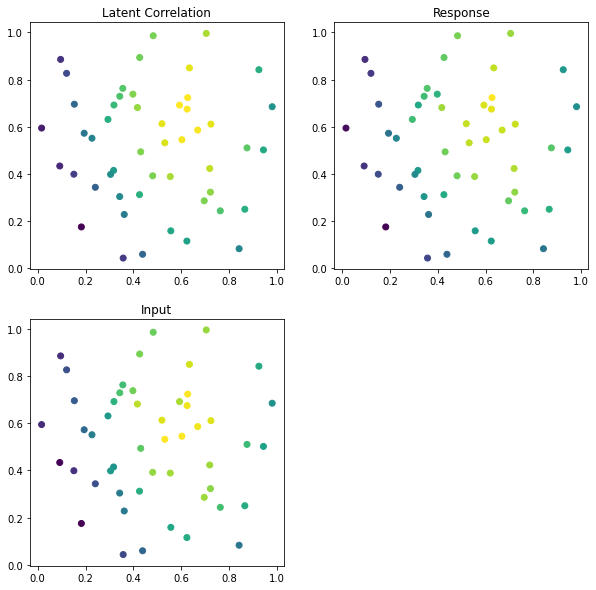

In [11]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.spatial import distance_matrix
#import matplotlib.mlab as ml
from scipy.interpolate import griddata

np.random.seed(123)

N = 50
noise = 1e-1

latlong = np.random.uniform(size=[N,2])

dists = distance_matrix(latlong, latlong)

ell = 5.e-1
K = np.exp(-np.square(dists)/ell)
K = K + 1e-6 * np.eye(N)
L = np.linalg.cholesky(K)
random_field = L @ np.random.normal(size=N)

x = np.random.normal(size=N)
#x = random_field + 0.1 * np.random.normal(size=N)
y = (x * 0.5).flatten() + random_field + np.random.normal(size=N,scale=noise)
#y = random_field + np.random.normal(size=N,scale=noise)

fig = plt.figure(figsize=[10,10])
plt.subplot(2,2,1)
plt.scatter(latlong[:,0], latlong[:,1], c = random_field)
plt.title("Latent Correlation")
plt.subplot(2,2,2)
plt.scatter(latlong[:,0], latlong[:,1], c = y)
plt.title("Response")
plt.subplot(2,2,3)
plt.scatter(latlong[:,0], latlong[:,1], c = x)
plt.title("Input")


In [12]:
fit = sm.OLS(y, x)
results = fit.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              9175.
Date:                Tue, 16 Nov 2021   Prob (F-statistic):                    2.11e-57
Time:                        15:34:38   Log-Likelihood:                          30.662
No. Observations:                  50   AIC:                                     -59.32
Df Residuals:                      49   BIC:                                     -57.41
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9902      0.010     95.785      0.000       0.969       1.011
==============================================================================
Omnibus:                        2.616   Durbin-Watson:                   1.496
Prob(Omnibus):                  0.270   Jarque-Bera (JB):                1.656
Skew:                           0.363   Prob(JB):                        0.437
Kurtosis:                       3.517   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
corrmat = K + np.square(noise)*np.eye(N)
fit = sm.GLS(y, x, sigma = corrmat)
results = fit.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 GLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.062
Model:                            GLS   Adj. R-squared (uncentered):              0.043
Method:                 Least Squares   F-statistic:                              3.233
Date:                Tue, 16 Nov 2021   Prob (F-statistic):                      0.0783
Time:                        15:34:39   Log-Likelihood:                          24.596
No. Observations:                  50   AIC:                                     -47.19
Df Residuals:                      49   BIC:                                     -45.28
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2515      0.140      1.798      0.078      -0.030       0.533
==============================================================================
Omnibus:                        6.436   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.040   Jarque-Bera (JB):               10.159
Skew:                          -0.089   Prob(JB):                      0.00622
Kurtosis:                       5.201   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""